In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Reading in the Data

In [108]:
yac_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/interception_training_tensor.csv")

In [109]:
yac_data.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId3,playId2,defenseId,offenseId,defense_s_x,...,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s
0,test,2018090600,3392,79848,310,1,1,1,1,0.895785,...,4.00,-2.67,1.982733,-0.654441,0.585047,4.189346,14.22,-17.87,-27.19,5.87
1,test,2018090600,3392,79848,2533040,1,1,1,2,0.895785,...,-9.93,-1.81,1.261704,-0.547037,0.585047,4.189346,14.22,-17.87,-27.19,5.87
2,test,2018090600,3392,79848,2543583,1,1,1,3,0.895785,...,3.86,-0.17,1.512791,1.541616,0.585047,4.189346,14.22,-17.87,-27.19,5.87
3,test,2018090600,3392,79848,2555415,1,1,1,4,0.895785,...,-22.80,14.40,-1.411428,4.733425,0.585047,4.189346,14.22,-17.87,-27.19,5.87
4,test,2018090600,3392,79848,2560854,1,1,1,5,0.895785,...,-11.24,-11.88,0.168013,5.013949,0.585047,4.189346,14.22,-17.87,-27.19,5.87
5,test,2018090600,3392,2495613,310,1,1,2,1,-0.933663,...,15.72,1.75,0.153285,3.115423,0.585047,4.189346,14.22,-6.15,-22.77,5.87
6,test,2018090600,3392,2495613,2533040,1,1,2,2,-0.933663,...,1.79,2.61,-0.567744,3.222827,0.585047,4.189346,14.22,-6.15,-22.77,5.87
7,test,2018090600,3392,2495613,2543583,1,1,2,3,-0.933663,...,15.58,4.25,-0.316657,5.311479,0.585047,4.189346,14.22,-6.15,-22.77,5.87
8,test,2018090600,3392,2495613,2555415,1,1,2,4,-0.933663,...,-11.08,18.82,-3.240876,8.503288,0.585047,4.189346,14.22,-6.15,-22.77,5.87
9,test,2018090600,3392,2495613,2560854,1,1,2,5,-0.933663,...,0.48,-7.46,-1.661435,8.783813,0.585047,4.189346,14.22,-6.15,-22.77,5.87


In [110]:
yac_data.shape

(32400, 25)

In [111]:
target_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/interception_training_target.csv")

In [112]:
target_data.head(10)

,group,gameId,playId,playId2,playId3,offensePlayResult,offensePlayResult_adj
0,test,2018090600,3392,1,1,11,11
1,test,2018090903,2230,2,8,-4,-4
2,test,2018091601,3575,3,29,14,14
3,test,2018092303,2913,4,50,25,25
4,test,2018092306,801,5,51,16,16
5,test,2018092310,1414,6,56,6,6
6,test,2018093000,2991,7,67,-9,-9
7,test,2018093006,2852,8,76,35,35
8,test,2018100400,3866,9,89,-17,-17
9,test,2018100700,1307,10,90,10,10


# Formatting the Data

In [113]:
yac_data.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId3', 'playId2', 'defenseId', 'offenseId', 'defense_s_x',
       'defense_s_y', 'defense_receiver_x', 'defense_receiver_y',
       'defense_receiver_s_x', 'defense_receiver_s_y', 'defense_offense_x',
       'defense_offense_y', 'defense_offense_s_x', 'defense_offense_s_y',
       'receiver_s_x', 'receiver_s_y', 'receiver_distance_from_los',
       'defense_football_x', 'defense_football_y', 'football_s'],
      dtype='object')

In [114]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId', 'playId3','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [115]:
X_train = create_x(data = yac_data[yac_data["group"] == "training"],
                  nfeatures = 16)

In [116]:
X_train.shape

(452, 11, 10, 16)

In [117]:
X_train[0][0][0]

array([  5.868363 ,   3.1703653,   1.25     , -16.28     ,   1.9394224,
        -1.2177466,  -3.37     , -34.29     ,  -2.0850422,   2.0639093,
         3.9289408,   4.3881116,  16.35     ,   4.22     , -16.4      ,
        17.93     ], dtype=float32)

In [118]:
X_validation = create_x(data = yac_data[(yac_data["group"] == "validation")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 16)

In [119]:
X_validation.shape

(49, 11, 10, 16)

In [120]:
X_validation[0][0][0]

array([-0.7682554, -6.9476533,  1.57     ,  4.66     , -4.537274 ,
       -5.333807 , 10.39     , -4.69     , -0.4911405, -6.7338605,
        3.7690184, -1.6138463,  2.35     ,  2.78     ,  3.26     ,
       20.34     ], dtype=float32)

In [121]:
X_test = create_x(data = yac_data[(yac_data["group"] == "test")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 16)

In [122]:
X_test.shape

(49, 11, 10, 16)

In [123]:
X_test[0][0][0]

array([  0.89578533,   0.9282611 , -20.08      , -27.38      ,
         0.31073877,  -3.261085  ,   4.        ,  -2.67      ,
         1.9827329 ,  -0.6544407 ,   0.5850465 ,   4.1893463 ,
        14.22      , -17.87      , -27.19      ,   5.87      ],
      dtype=float32)

In [124]:
def create_y(data):
    targets = np.array(data["offensePlayResult_adj"])
    
    y = np.zeros((targets.shape[0], 199))
    for idx, target in enumerate(list(targets)):
        y[idx][99 + target] = 1
    
    return(y)

In [125]:
y_train = create_y(data = target_data[(target_data["group"] == "training")])

In [126]:
y_train.shape

(452, 199)

In [127]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [128]:
y_validation = create_y(data = target_data[(target_data["group"] == "validation")&(target_data["gameId"] < 20000000000)])

In [129]:
y_validation.shape

(49, 199)

In [130]:
y_test = create_y(data = target_data[(target_data["group"] == "test") & (target_data["gameId"] < 20000000000)])

In [131]:
y_test.shape

(49, 199)

In [132]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Training a Convolutional Neural Network Model

In [151]:
model = tf.keras.Sequential()

In [152]:
# first convolutional neural network
model.add(layers.Conv2D(50, 
                        kernel_size=(1,1), 
                        strides=(1,1), 
                        input_shape = (11,10,16)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(100, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(50, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))

import tensorflow.keras.backend as K

def channelPool(x):
    return .5*K.max(x,axis=2) + .5*K.mean(x,axis=2)

model.add(layers.Lambda(channelPool))

In [153]:
# second convolutional neural network
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(50, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(100, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(50, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
# model.add(layers.AvgPool2D(pool_size=(11, 1)))

def channelPool(x):
    return .5*K.max(x,axis=1) + .5*K.mean(x,axis=1)

model.add(layers.Lambda(channelPool))

In [154]:
model.add(layers.Flatten())
model.add(layers.Dense(96))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(199))
model.add(layers.Activation('softmax'))

In [155]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 11, 10, 50)        850       
_________________________________________________________________
activation_72 (Activation)   (None, 11, 10, 50)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 10, 100)       5100      
_________________________________________________________________
activation_73 (Activation)   (None, 11, 10, 100)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 10, 50)        5050      
_________________________________________________________________
activation_74 (Activation)   (None, 11, 10, 50)        0         
_________________________________________________________________
lambda_16 (Lambda)           (None, 11, 50)           

In [156]:
import tensorflow.keras.backend as K
def crps(y_true, y_pred):
    y_pred =  K.cumsum(y_pred, axis=1)
    ym =  K.cast(K.reshape(K.argmax(y_true, axis=1) - 99, (-1, 1)), 
        dtype='int32')
    n = K.arange(-99, 100)
    step = K.cast(K.greater_equal(n - ym, 0), dtype='float32')
    return K.mean(K.sum(K.square(y_pred - step), axis=1)) / 199

In [157]:
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

In [158]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=[crps], metrics=[crps], optimizer='adam')

In [159]:
history = model.fit(X_train, y_train,
                   validation_data = (X_validation, y_validation),
                   # batch_size = 64,
                   epochs = 25,
                   verbose = 1)

Epoch 1/25
15/15 [==============================] - 1s 41ms/step - loss: 0.0914 - crps: 0.0900 - val_loss: 0.0957 - val_crps: 0.0942
Epoch 2/25
15/15 [==============================] - 0s 16ms/step - loss: 0.0720 - crps: 0.0709 - val_loss: 0.0939 - val_crps: 0.0926
Epoch 3/25
15/15 [==============================] - 0s 20ms/step - loss: 0.0589 - crps: 0.0615 - val_loss: 0.0907 - val_crps: 0.0896
Epoch 4/25
15/15 [==============================] - 0s 20ms/step - loss: 0.0536 - crps: 0.0528 - val_loss: 0.0863 - val_crps: 0.0853
Epoch 5/25
15/15 [==============================] - 0s 20ms/step - loss: 0.0512 - crps: 0.0519 - val_loss: 0.0812 - val_crps: 0.0802
Epoch 6/25
15/15 [==============================] - 0s 19ms/step - loss: 0.0491 - crps: 0.0487 - val_loss: 0.0754 - val_crps: 0.0744
Epoch 7/25
15/15 [==============================] - 0s 19ms/step - loss: 0.0492 - crps: 0.0488 - val_loss: 0.0696 - val_crps: 0.0685
Epoch 8/25
15/15 [==============================] - 0s 22ms/step - lo

In [160]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0473 - crps: 0.0454


[0.04728379845619202, 0.045415908098220825]

# Examining Results

The plays analyzed are part of the holdout set, so the CNN model did not ever see the data in training, or indirectly through optimizing the crps of the cross-validation set.

### Play that Went For Negative Yardage

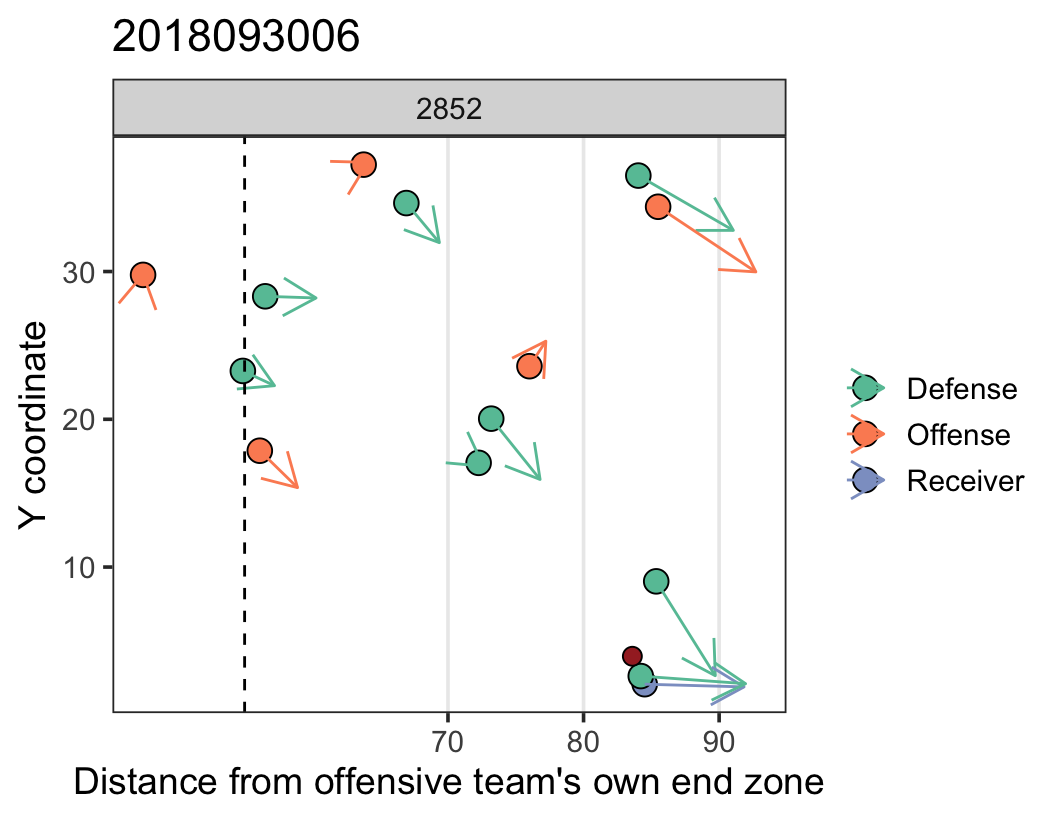

In [161]:
yac_data[(yac_data["gameId"] == 2018093006) & (yac_data["playId"] == 2852)]["playId2"].iloc[0]

8

In [162]:
yards = target_data[(target_data["gameId"] == 2018093006) & (target_data["playId"] == 2852)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 35 gain.


In [163]:
np.argmax(y_test[8-1]) - 99

35

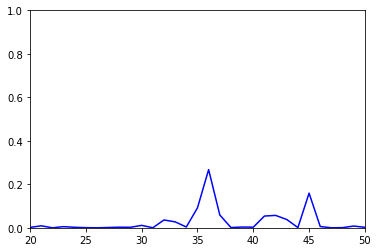

In [165]:
plt.plot(np.arange(-99,100), model.predict(X_test)[7], 'b-')
plt.xlim(20,50)
plt.ylim(0,1)
plt.show()

In [166]:
# yardage prediction
model.predict(X_test)[7].dot(np.arange(-99,100))

33.83870244214174

### Play that Went For No Yardage

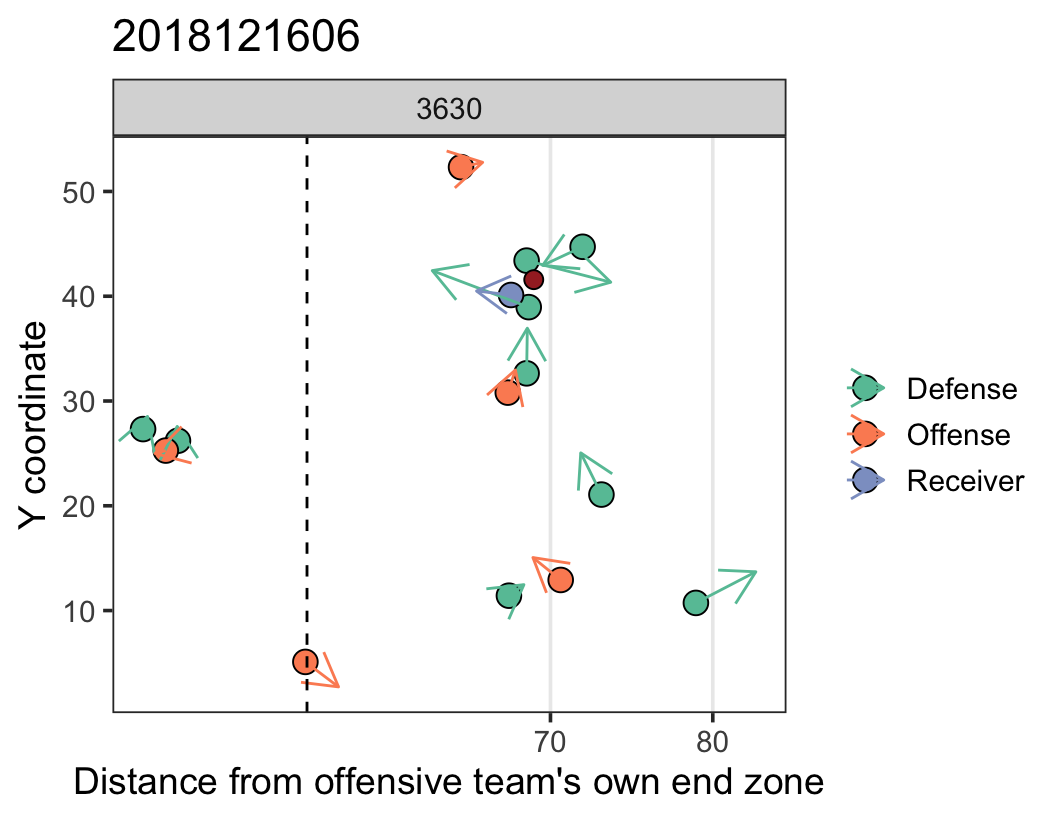

In [167]:
yac_data[(yac_data["gameId"] == 2018121606) & (yac_data["playId"] == 3630)]["playId2"].iloc[0]

42

In [168]:
yards = target_data[(target_data["gameId"] == 2018121606) & (target_data["playId"] == 3630)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 0 gain.


In [169]:
np.argmax(y_test[42-1]) - 99

0

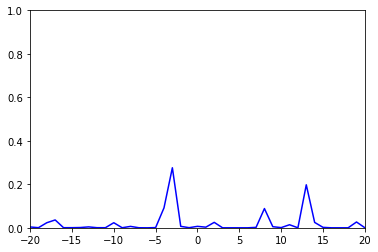

In [172]:
plt.plot(np.arange(-99,100), model.predict(X_test)[41], 'b-')
plt.xlim(-20,20)
plt.ylim(0,1)
plt.show()

In [173]:
# yardage prediction
model.predict(X_test)[41].dot(np.arange(-99,100))

-0.9662986529129114

### Play that Went For 10 Yards

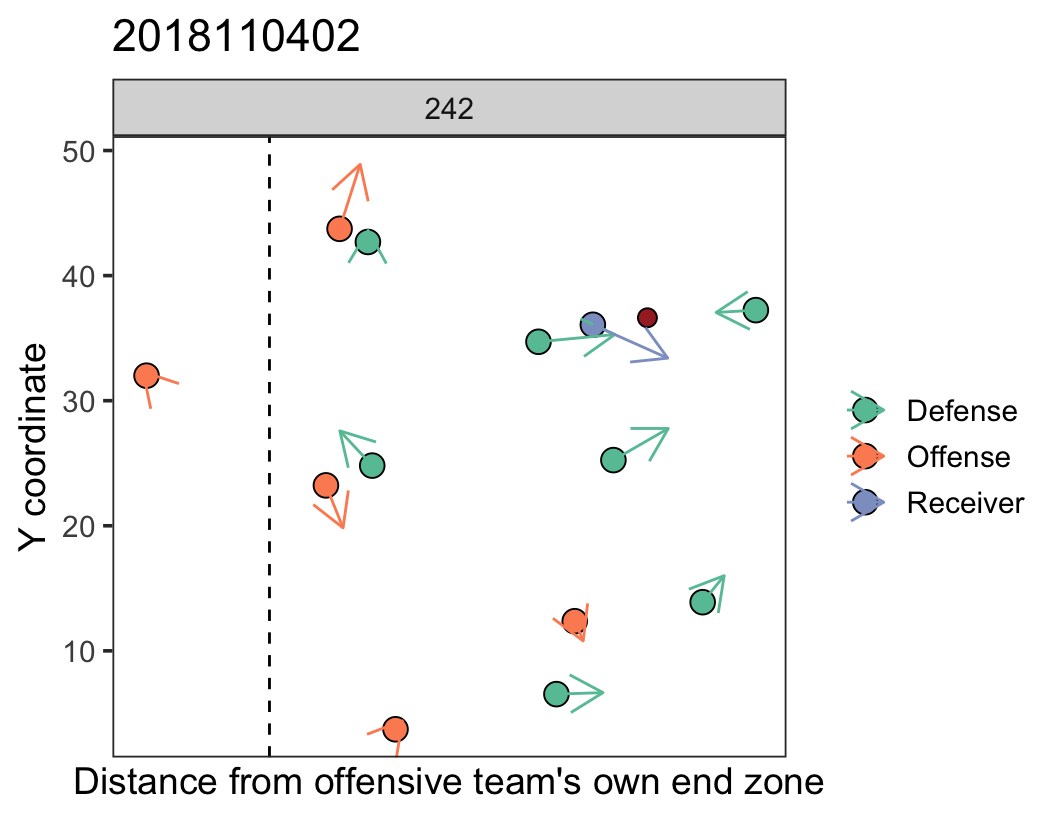

In [174]:
yac_data[(yac_data["gameId"] == 2018110402) & (yac_data["playId"] == 242)]["playId2"].iloc[0]

26

In [175]:
yards = target_data[(target_data["gameId"] == 2018110402) & (target_data["playId"] == 242)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a -12 gain.


In [176]:
np.argmax(y_test[26-1]) - 99

-12

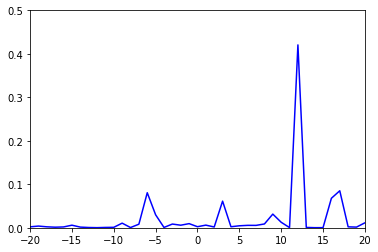

In [179]:
plt.plot(np.arange(-99,100), model.predict(X_test)[25], 'b-')
plt.xlim(-20,20)
plt.ylim(0,.5)
plt.show()

In [180]:
# yardage prediction
model.predict(X_test)[25].dot(np.arange(-99,100))

8.470139522876707

### Play that Went For 30+ Yards

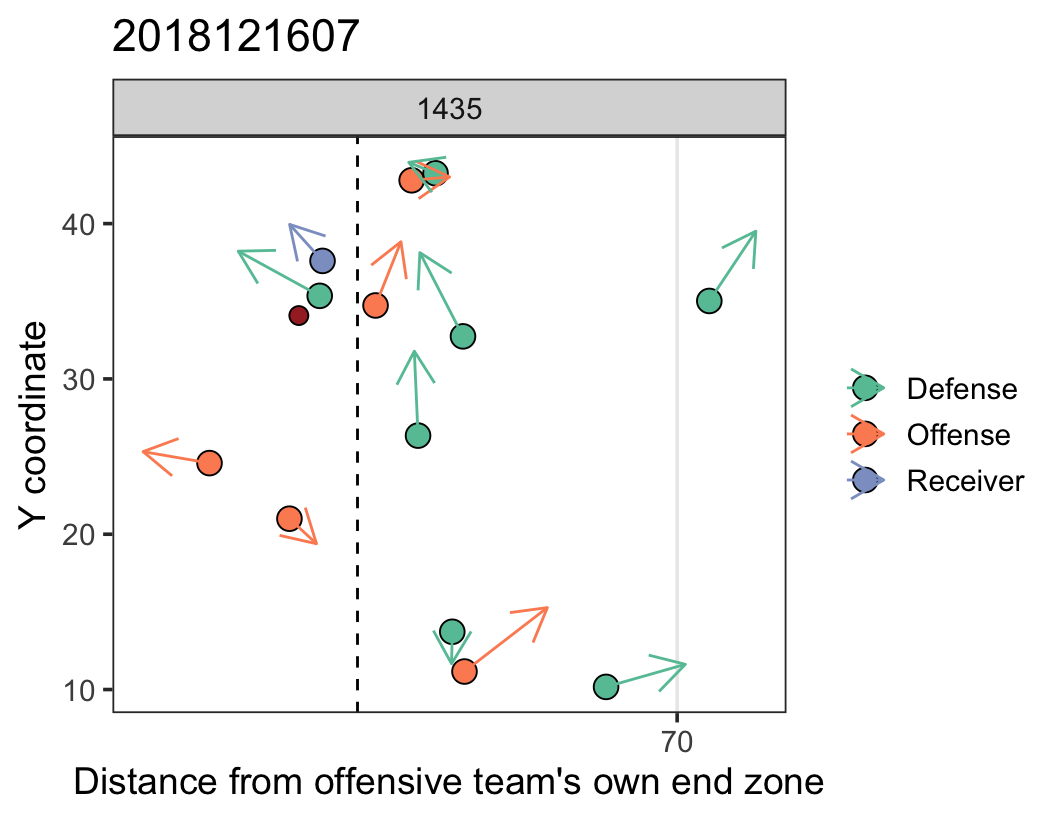

In [183]:
yac_data[(yac_data["gameId"] == 2018121607) & (yac_data["playId"] == 1435)]["playId2"].iloc[0]

43

In [181]:
yards = target_data[(target_data["gameId"] == 2018121607) & (target_data["playId"] == 1435)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a -53 gain.


In [184]:
np.argmax(y_test[43-1]) - 99

-50

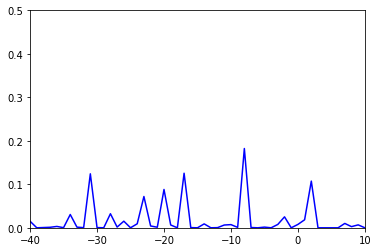

In [187]:
plt.plot(np.arange(-99,100), model.predict(X_test)[42], 'b-')
plt.xlim(-40,10)
plt.ylim(0,.5)
plt.show()

In [188]:
# yardage prediction
model.predict(X_test)[42].dot(np.arange(-99,100))

-15.964995382406748

# Scoring Entire Data Set

In [189]:
pass_arrived_score = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/pass_arrived_score_tensor.csv")

In [190]:
pass_arrived_score.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,...,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s,receiver_football_defender_dist_diff,defender_receiver_football_dist_diff
0,full,2018090600,75,79848,310,1,1,1,0.854323,-7.521638,...,0.866988,-6.931774,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
1,full,2018090600,75,79848,2533040,1,1,2,0.854323,-7.521638,...,-1.580489,-5.786186,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
2,full,2018090600,75,79848,2543583,1,1,3,0.854323,-7.521638,...,-2.652919,-5.933634,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
3,full,2018090600,75,79848,2555415,1,1,4,0.854323,-7.521638,...,-1.216309,-14.260702,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
4,full,2018090600,75,79848,2559033,1,1,5,0.854323,-7.521638,...,-0.722724,-14.146517,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
5,full,2018090600,75,0,0,1,1,6,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
6,full,2018090600,75,0,0,1,1,7,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
7,full,2018090600,75,0,0,1,1,8,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
8,full,2018090600,75,0,0,1,1,9,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
9,full,2018090600,75,0,0,1,1,10,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000


In [191]:
pass_arrived_score.shape

(1558590, 26)

In [192]:
pass_arrived_score2 = pass_arrived_score.drop(['receiver_football_defender_dist_diff', 
                                                'defender_receiver_football_dist_diff'],
                                            axis = 1)

In [193]:
pass_arrived_score2.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,...,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s
0,full,2018090600,75,79848,310,1,1,1,0.854323,-7.521638,...,13.96,-17.66,0.866988,-6.931774,-1.624206,-3.905746,8.89,0.95,1.29,12.68
1,full,2018090600,75,79848,2533040,1,1,2,0.854323,-7.521638,...,-4.68,-9.66,-1.580489,-5.786186,-1.624206,-3.905746,8.89,0.95,1.29,12.68
2,full,2018090600,75,79848,2543583,1,1,3,0.854323,-7.521638,...,8.79,-14.65,-2.652919,-5.933634,-1.624206,-3.905746,8.89,0.95,1.29,12.68
3,full,2018090600,75,79848,2555415,1,1,4,0.854323,-7.521638,...,-3.99,-28.44,-1.216309,-14.260702,-1.624206,-3.905746,8.89,0.95,1.29,12.68
4,full,2018090600,75,79848,2559033,1,1,5,0.854323,-7.521638,...,4.79,-34.25,-0.722724,-14.146517,-1.624206,-3.905746,8.89,0.95,1.29,12.68
5,full,2018090600,75,0,0,1,1,6,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
6,full,2018090600,75,0,0,1,1,7,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
7,full,2018090600,75,0,0,1,1,8,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
8,full,2018090600,75,0,0,1,1,9,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
9,full,2018090600,75,0,0,1,1,10,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00


In [194]:
pass_arrived_score2.shape

(1558590, 24)

# Formatting the Data

In [195]:
pass_arrived_score.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId2', 'defenseId', 'offenseId', 'defense_s_x', 'defense_s_y',
       'defense_receiver_x', 'defense_receiver_y', 'defense_receiver_s_x',
       'defense_receiver_s_y', 'defense_offense_x', 'defense_offense_y',
       'defense_offense_s_x', 'defense_offense_s_y', 'receiver_s_x',
       'receiver_s_y', 'receiver_distance_from_los', 'defense_football_x',
       'defense_football_y', 'football_s',
       'receiver_football_defender_dist_diff',
       'defender_receiver_football_dist_diff'],
      dtype='object')

In [196]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [197]:
X_score = create_x(data = pass_arrived_score2,
                  nfeatures = 16)

In [198]:
X_score.shape

(14169, 11, 10, 16)

In [199]:
X_score[0][0][0]

array([  0.85432285,  -7.5216374 ,  -1.23      ,   2.69      ,
         2.4785287 ,  -3.6158912 ,  13.96      , -17.66      ,
         0.8669877 ,  -6.9317737 ,  -1.624206  ,  -3.9057465 ,
         8.89      ,   0.95      ,   1.29      ,  12.68      ],
      dtype=float32)

# Saving Predictions

In [200]:
score_preds = model.predict(X_score)

In [217]:
score_preds[0]

array([1.9506996e-03, 1.5371479e-04, 1.5680965e-04, 7.1655748e-05,
       1.4967205e-04, 3.0265814e-05, 2.8498881e-04, 4.0222306e-04,
       4.5399999e-04, 2.1661069e-04, 3.6696470e-04, 6.5952649e-05,
       1.8420284e-04, 1.7768717e-03, 1.0515049e-04, 1.1293503e-03,
       9.0536667e-04, 1.2131989e-04, 7.7377359e-04, 2.1837883e-04,
       1.1900587e-04, 2.7796353e-04, 1.3882684e-04, 2.9284265e-04,
       3.7996480e-04, 2.3949138e-04, 6.1677964e-03, 2.0195739e-04,
       2.1636263e-04, 8.4393792e-04, 4.7655808e-04, 3.4332721e-04,
       9.1368880e-04, 1.7399567e-03, 2.3389493e-04, 4.4147318e-04,
       2.7532227e-04, 4.1835749e-05, 2.0673987e-03, 8.6318958e-04,
       2.7257475e-04, 3.1797288e-05, 3.5261217e-04, 3.1930066e-04,
       4.7661058e-05, 4.9515819e-04, 3.1080097e-04, 2.7081877e-04,
       8.0194703e-05, 2.7994267e-03, 2.7578213e-04, 5.0755718e-04,
       1.7011651e-03, 6.8108202e-03, 6.8052963e-04, 2.5916551e-04,
       2.1677437e-04, 4.3467153e-03, 6.4054038e-04, 8.7371804e

In [202]:
full_preds_df = pd.DataFrame(score_preds, columns = [str(int(x - 99)) for x in np.linspace(0,198, 199)])

In [203]:
full_preds_df.shape

(14169, 199)

In [211]:
full_preds_df2 = pd.concat([pass_arrived_score2[["gameId","playId"]].drop_duplicates().reset_index(), full_preds_df], axis = 1)
full_preds_df2 = full_preds_df2[full_preds_df2["gameId"] < 10000000000]
full_preds_df2 = full_preds_df2.drop(['index'], axis = 1)

In [212]:
full_preds_df2.shape

(14169, 201)

In [213]:
full_preds_df2.head(10)

,gameId,playId,-99,-98,-97,-96,-95,-94,-93,-92,...,90,91,92,93,94,95,96,97,98,99
0,2018090600,75,0.001951,0.000154,0.000157,0.000072,0.000150,0.000030,0.000285,0.000402,...,0.000198,0.000470,0.000439,0.000275,0.000329,0.000078,0.000634,0.000267,0.000334,0.000413
1,2018090600,146,0.001686,0.000152,0.000175,0.000127,0.000395,0.000023,0.000518,0.000176,...,0.000225,0.001006,0.000985,0.000234,0.000325,0.000073,0.000589,0.000199,0.000313,0.000486
2,2018090600,190,0.000883,0.000478,0.001350,0.001965,0.000690,0.001047,0.000585,0.001121,...,0.002044,0.000900,0.000494,0.000849,0.001159,0.000397,0.001695,0.001243,0.000929,0.001107
3,2018090600,256,0.000404,0.000268,0.000225,0.000229,0.000309,0.000328,0.000512,0.000220,...,0.000205,0.000690,0.000724,0.000323,0.000295,0.000103,0.000489,0.000356,0.000328,0.000424
4,2018090600,320,0.000038,0.000004,0.000484,0.000138,0.000092,0.000092,0.000350,0.000126,...,0.000129,0.000036,0.000063,0.000175,0.000140,0.000310,0.000136,0.000037,0.000127,0.000116
5,2018090600,402,0.000509,0.000357,0.000253,0.000315,0.000452,0.000741,0.000426,0.000776,...,0.000595,0.000376,0.000837,0.000554,0.000592,0.001725,0.000440,0.001076,0.000448,0.000788
6,2018090600,492,0.000291,0.000036,0.000232,0.000038,0.000127,0.000082,0.000163,0.000040,...,0.000422,0.000079,0.000071,0.000562,0.000291,0.000108,0.000138,0.000210,0.000481,0.000250
7,2018090600,521,0.000654,0.000221,0.000443,0.000197,0.000395,0.000189,0.000409,0.000099,...,0.000761,0.000215,0.000529,0.001119,0.000848,0.000234,0.000346,0.000967,0.000855,0.001290
8,2018090600,752,0.000621,0.000035,0.000608,0.000181,0.000275,0.000095,0.000351,0.000068,...,0.000254,0.000249,0.000212,0.000432,0.000599,0.000215,0.000487,0.000267,0.000209,0.000193
9,2018090600,949,0.000011,0.000007,0.000010,0.000002,0.000011,0.000022,0.000017,0.000001,...,0.000074,0.000004,0.000007,0.000360,0.000058,0.000013,0.000015,0.000028,0.000074,0.000058


In [214]:
full_preds_df3 = pd.melt(full_preds_df2, 
        id_vars=['gameId', 'playId'], 
        value_vars=[str(int(x - 99)) for x in np.linspace(0,198, 199)],
        var_name='offensePlayResult', 
        value_name='probability')

full_preds_df3["offensePlayResult"] = [int(x) for x in np.array(full_preds_df3["offensePlayResult"])]
full_preds_df3 = full_preds_df3.sort_values(['gameId','playId','offensePlayResult'])

In [215]:
full_preds_df3.head(10)

,gameId,playId,offensePlayResult,probability
0,2018090600,75,-99,0.001951
14169,2018090600,75,-98,0.000154
28338,2018090600,75,-97,0.000157
42507,2018090600,75,-96,0.000072
56676,2018090600,75,-95,0.000150
70845,2018090600,75,-94,0.000030
85014,2018090600,75,-93,0.000285
99183,2018090600,75,-92,0.000402
113352,2018090600,75,-91,0.000454
127521,2018090600,75,-90,0.000217


In [216]:
full_preds_df3.shape

(2819631, 4)

In [218]:
full_preds_df3.to_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/interceptions_yards_probs.csv", 
                        index = False)